# Make your own mock data and write your own MCMC

Aim: Understand and write a simple MCMC code that can sample a likelihood surface, then plot results. 

In [1]:
# Import your libraries:

# Genral imports
import numpy as np

# Plotting imports
import matplotlib.pylab as plt
from matplotlib import colors as mcolors

## A: Create a data vector

First step of the assignment is to create a toy data vector. We start by using this simple function. You can play with other functions later. 

In [2]:
# A simple function with two variables
def mockdata(x,a,b):
    return a*np.log10(x)+b

Now define 9 $x$ values between 0.5 and 300.0 in log10 space. We are going to set $a$ and $b$ to the values below for now. 

In [3]:
# Define 9 x values between 0.5 and 300 in logspace
xmin = 0.5
xmax = 300.0
nx   = 9
x = np.logspace(np.log10(xmin), np.log10(xmax), nx)

# Set the input a and b values
a = 0.75
b = 0.3

# Create a mock data vector,call it y_th using the simple function: mockdata for the above x values 
y_th = mockdata(x,a,b)

## B: Add noise to mock data
We want to make a data vector that resembles real data. Real data has noise, so lets add noise to our theoretical model. 

### Add noise

Now create a noise realisation by randomly picking from a Gaussian distribution (hint: you can use np.random.normal to do this)

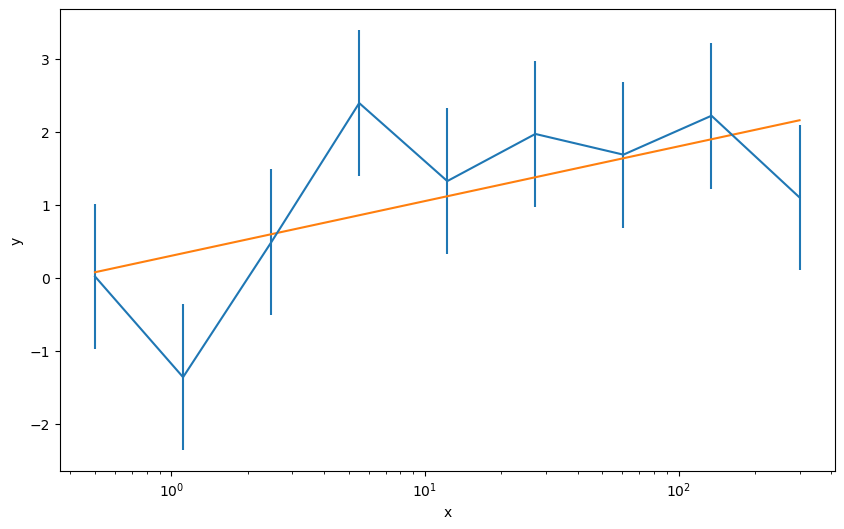

In [4]:
# Create noise realisation Gaussian independent error
sigma = 1. 
noise_realisation = np.random.normal(0.,sigma,nx)

# we are going to use this later, this is a nx times nx diagonal covariance with the diagonal elements equal to sigma
cov = np.diag(np.ones(nx)*sigma)

# Add noise to the theoretical data vector
y_data = y_th + noise_realisation

# plot y_th and y_data (with errorbars, hint: you can use plt.errorbar) 
plt.figure(figsize=(10,6))
plt.xscale('log')
plt.errorbar(x,y_data,yerr=sigma)
plt.plot(x,y_th,'-')
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("xy.png")

## C: Fit the model to the data

In this example we know the true model and the value of its parameters (we defined it ourselves!). In reality we won't know that. So for now lets forget that we already have this information and try to find a fit to our data.


### C.1: Define $\chi^2$

The $\chi^2$ function for a general case is 

\begin{equation}
\chi^2=\sum_{i,j}^{N}[y_i-\mu_i(\Phi)](C^{-1})_{ij}[y_j-\mu_j(\Phi)]\;,
\end{equation}

where $\mu_i$ are the expected values of the observables, $y_i$, 
and $C^{-1}$ is the inverse covariance matrix. 
The $\chi^2$ fitting is a generalized (weighted) form of least-square fitting.
To see why notice that if the covariance is a diagonal matrix with equal diagonal components , 
$\sigma^2$ (like we had in B.1), the simple least-square formula is attained,

\begin{equation}
 \chi^2_\mathrm{simple}=\frac{1}{\sigma^2}\sum_{i}^{N}[y_i-\mu_i(\Phi)]^2\;,
\end{equation}

and minimizing this simplified $\chi^2$ results in finding the best fitting values.

Notice that the general definition can be simplied using matrix multiplication:

\begin{equation}
\chi^2=\Delta \mathbf{y}\; C^{-1}\; \Delta \mathbf{y}^t \;,
\end{equation}

where $\Delta \mathbf{y} = \mathbf{y}-\mathbf{\mu}$ is a vector.

In [5]:
# define a chi^2 function based on the last equation above.
def chisq_func(y_data,y_th,cov):
    delta_y = y_data - y_th
    chisq = np.dot(delta_y,np.dot(np.linalg.inv(cov),np.transpose(delta_y)))
    return chisq

### C.2 What does the $\chi^2$ value tell us?

We can use $\chi^2$ to define our likelihood. But $\chi^2$ by itself has meaning. To find out
Run the code from B.2 again and notice that the chisq value changes. Repeat this for 1000s of noise realisations and plot the chisq distribution. 

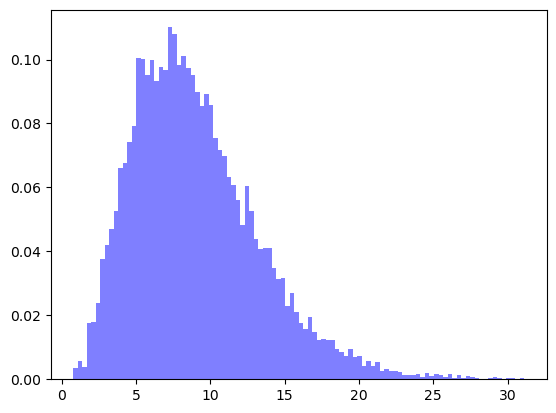

In [17]:
# Number of realisations. You can change this and see how the distribution converges
nReal = 10000
# 

error = np.random.multivariate_normal(np.zeros(nx),cov,nReal)

# Add noise to the theoretical data vector
chisq_arr=np.zeros(nReal)
for r in range(nReal):
    y_data=y_th + error[r,:]
    chisq = chisq_func(y_data, y_th, cov)
    chisq_arr[r] = chisq

#y_data = y_th + error

#chisq_arr=chisq_func(y_data,y_th,cov)
#print(chisq_arr)

# example histogram plot, assuming that chisq is an array of chi^2 values with the same length as nReal
counts=plt.hist(chisq_arr,color='blue', range=(chisq_arr.min(),chisq_arr.max()), bins=100, density=True, alpha=0.5,histtype='stepfilled',label=r"Mock data chi^2")

## C.3 Chi squared distribution

What you have plotted above is the distribution $\chi^2$ values, which follows a $\chi^2$ distribution if your data is Gaussian distributed. Mathematically it looks like this:

\begin{equation}
p(x=\chi^2) = \frac{x^{d/2-1} e^{-x/2} }{2^{d/2} \Gamma(d/2)}
\end{equation}

where $d$ is the degrees-of-freedom and the \Gamma function is a generalised form of factorial function that works for non-integer numbers as well. 

This distribution tends to a Gaussian for $d \rightarrow \infty$. The mean of the distribution is $d$ and its variance is $2d$.

Python already has this coded up in scipy (scipy.stats.chi2.pdf). Your next task is to overplot a theoretical $\chi^2$ distribution on top of the histogram that your plotted above. 

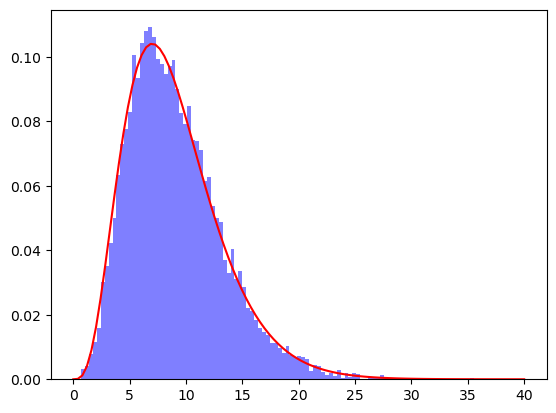

In [7]:
# Import scipy and use it to plot a chi2 distribution (a curve) on top of your histogram. 
from scipy.stats import chi2

chi2_x=np.linspace(0,40,100)
p=chi2.pdf(chi2_x, 9)

plt.plot(chi2_x, p, color='red')
counts=plt.hist(chisq_arr,color='blue', range=(chisq_arr.min(),chisq_arr.max()), bins=100, density=True, alpha=0.5,histtype='stepfilled',label=r"Mock data chi^2")

# What is the degrees-of-freedom? 







## C.4 $p$-value: Probability to Exceed

A $\chi^2$ value by itself is difficult to decipher. Sometime people use the reduced $\chi^2$,

\begin{equation}
\chi^2_{\rm red}=\frac{\chi^2}{d}, 
\end{equation}

to simplify the problem. In this case one would say that a $\chi^2_{\rm red}\sim 1$ shows that the model is a good fit to the data. But how close? That would depend on $d$. A better way to do this is to use the $p$-value,

\begin{equation}
p{\rm -value}= P(\chi^2>\chi_{\rm m}^2| {\rm Model}) = \int_{\chi_{\rm m}}^{\infty} {\rm d} \chi^2 p(\chi^2| {\rm Model}),
\end{equation}

where $\chi^2_{\rm m}$ is your measured $\chi^2$. 

Usually you set a $p$-value threshold in advance for example, 0.05 or 0.01 or 0.001, then if you find that your $p$-value is smaller than this you conclude that your have a bad fit and therefore there is something wrong with the Model. 

To understand the concept of $p$-value lets plot the distribution of $p$-values for all the $\chi^2$ values that you created in C.2. 


In [9]:
# Calculate the p-value for your nReal chi^2 values
# You don't need to take the integral yourself, because scipy can do that for you. Use chi2.sf to do so. 

# Plot the histogram, What is the expected distribution for $p$-value in your case?

# chi2.sf()


## C.5 $p$-value distribution for the wrong model

Now we are going to look at what happens to our $\chi^2$ distribution and $p$-values if the model doesn't match the data. We can do this exercise with two different functions, but for simplicity we will use the same simple function as before, but this time with a different $a$ and $b$, then repeat everything from C.2 to C.4. Keep your noise realisation and data the same as before (you can save these into an ndarray for example using stacking or append to a list of arrays). Change your y_th to the new value when you calculate $\chi^2$. The rest shoud be the same as above. 

[0.8370781  0.56466497 1.23386002 2.80094811 1.77606592 1.70865453
 1.81794198 1.58322746 2.59084797]


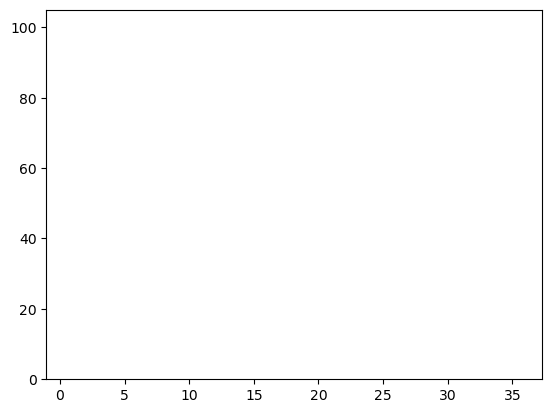

In [15]:
# define a new y_th using different a and b values
an = 1.5
bn = 0.0

#y_th_new = mockdata(x,a,b)

y_th_new = an*np.log10(x) + bn

# Calculate chi^2 for y_th_new and the original y_data nReal realisations 
nReal = 10000
# 

# error_new = np.random.multivariate_normal(np.zeros(nx),cov,nReal)
print(y_data)

# Add noise to the theoretical data vector

chisq_arr_new = np.zeros(nReal)
chisq_arr_ori = np.zeros(nReal)

for r in range(nReal):
    
    y_data_ori=y_th + error[r,:]
    y_data_new=y_th_new + error[r,:]
    
    chisq_orig = chisq_func(y_data_ori, y_th, cov)
    chisq_new = chisq_func(y_data, y_th_new, cov)
    
    chisq_arr_ori[r] = chisq_orig
    chisq_arr_new[r] = chisq_new

# print(chisq_arr_new)
    
# Plot the new chi^2 histogram on top of the old one. What do you see?
counts=plt.hist(chisq_arr_ori,     color='blue',    range=(chisq_arr_ori.min(),chisq_arr_ori.max()), bins=100, density=True, alpha=0.5,histtype='stepfilled',label=r"Mock data chi^2")
counts_new=plt.hist(chisq_arr_new, color='red',     range=(chisq_arr_new.min(),chisq_arr_new.max()), bins=100, density=True, alpha=0.5,histtype='stepfilled',label=r"Mock data chi^2")


In [16]:
# Calculate p-values for the new chi^2 values and plot them on top of the old ones. What do you see?





## D: Extras!

Congradulations! You've got this far. Hopefully you have a better understanding of goodness-of-fit. Here are some extra questions to answer or code up:

1. We set $a$ and $b$ to certain values above. What happens if you change that? Does it matter how far away they are from the origianl values? 

2. What if our errorbars were much smaller or larger? Does that impact the results? Repeat the exercise but change sigma to a different value (use the independent noise realisation for this). 

3. Lets say your data was drawn from a model (create a new function that is more complex). What if you tried to fit our original simple model to it? How would that change the chi^2 values. To do this you'll need to find the best fitting values for your parameters given a model. You can modify your MCMC code to do this. Repeat this for all noise realisations, once with the correct model (the more complex one that the data is created from) and then for the wrong model (the simple one we used at the start). Every time you run your code for a different realisation you'll get a different set of values for your parameters (keep this somewhere, e.g. an array or a list). Then calculate the $\chi^2$ for each case repeating C.1 to C.4. How does the $\chi^2$ distribution change for the correct model? What about the wrong model? How do they compare? 

4. Repeat the above exercise but with different error values. 

5. Imagine you have two models that are identical for one part of the data (say at large x they tend to the same value) but they are different for another part (e.g. at small x). What happens if you look at the $\chi^2$ values for the full data vector using both models, versus looking at only part of the data? First think about this and then come up with two models with this property and repeat C.2 to C.4 for them using all or part of the data. 